In [ ]:
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
import numpy as np

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# moves model to train on gpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
# check GPU properties
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(torch.cuda.device))

Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=2eb64a5c-e7c4-75b8-1b26-d73233692367, L2_cache_size=4MB)


In [ ]:
import zipfile
import os

with zipfile.ZipFile("melanoma.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# See what was extracted
os.listdir(".")

['.config',
 'drive',
 'archive',
 'melanoma.zip',
 'runs',
 '__MACOSX',
 'sample_data']

In [ ]:
# Fetching mean and std deviation for the correct normalization values

import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 as T
import numpy as np

# Resize & ToTensor only for statistics
stat_transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

train_ds_for_stats = datasets.ImageFolder(root="/content/archive/train", transform=stat_transform)
loader = DataLoader(train_ds_for_stats, batch_size=64, num_workers=4, shuffle=False)

n_pixels = 0
channel_sum = torch.zeros(3)
channel_sq_sum = torch.zeros(3)

for imgs, _ in loader:
    b, c, h, w = imgs.shape
    n = b * h * w
    n_pixels += n
    channel_sum += imgs.sum(dim=[0, 2, 3])
    channel_sq_sum += (imgs ** 2).sum(dim=[0, 2, 3])

mean = channel_sum / n_pixels
var = (channel_sq_sum / n_pixels) - mean**2
std = torch.sqrt(var)

print("Mean:", mean.tolist())
print("Std :", std.tolist())

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Mean: [0.7356305718421936, 0.5613219738006592, 0.5420768857002258]
Std : [0.1998678296804428, 0.19988155364990234, 0.21435679495334625]


In [ ]:
max_degree = 15

train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7356305718421936, 0.5613219738006592, 0.5420768857002258),
                                                           (0.1998678296804428, 0.19988155364990234, 0.21435679495334625))

])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.7356305718421936, 0.5613219738006592, 0.5420768857002258),
                                                          (0.1998678296804428, 0.19988155364990234, 0.21435679495334625))
])

In [ ]:
train_benign_path = "/content/archive/train/Benign"
train_malignant_path = "/content/archive/train/Malignant"
test_benign_path = "/content/archive/test/Benign"
test_malignant_path = "/content/archive/test/Malignant"

# Count images
print("Train Benign:", len(os.listdir(train_benign_path)))
print("Train Malignant:", len(os.listdir(train_malignant_path)))
print("Test Benign:", len(os.listdir(test_benign_path)))
print("Test Malignant:", len(os.listdir(test_malignant_path)))

Train Benign: 6289
Train Malignant: 5590
Test Benign: 1000
Test Malignant: 1000


In [ ]:
train_set = datasets.ImageFolder(root="/content/archive/train", transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.ImageFolder(root="/content/archive/test", transform=test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
print(train_set.classes)
print(train_set.class_to_idx)

['Benign', 'Malignant']
{'Benign': 0, 'Malignant': 1}


In [ ]:
training_data = enumerate(trainloader)

In [ ]:
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(batch_idx)
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
0
torch.Size([64, 3, 224, 224])
torch.Size([64])


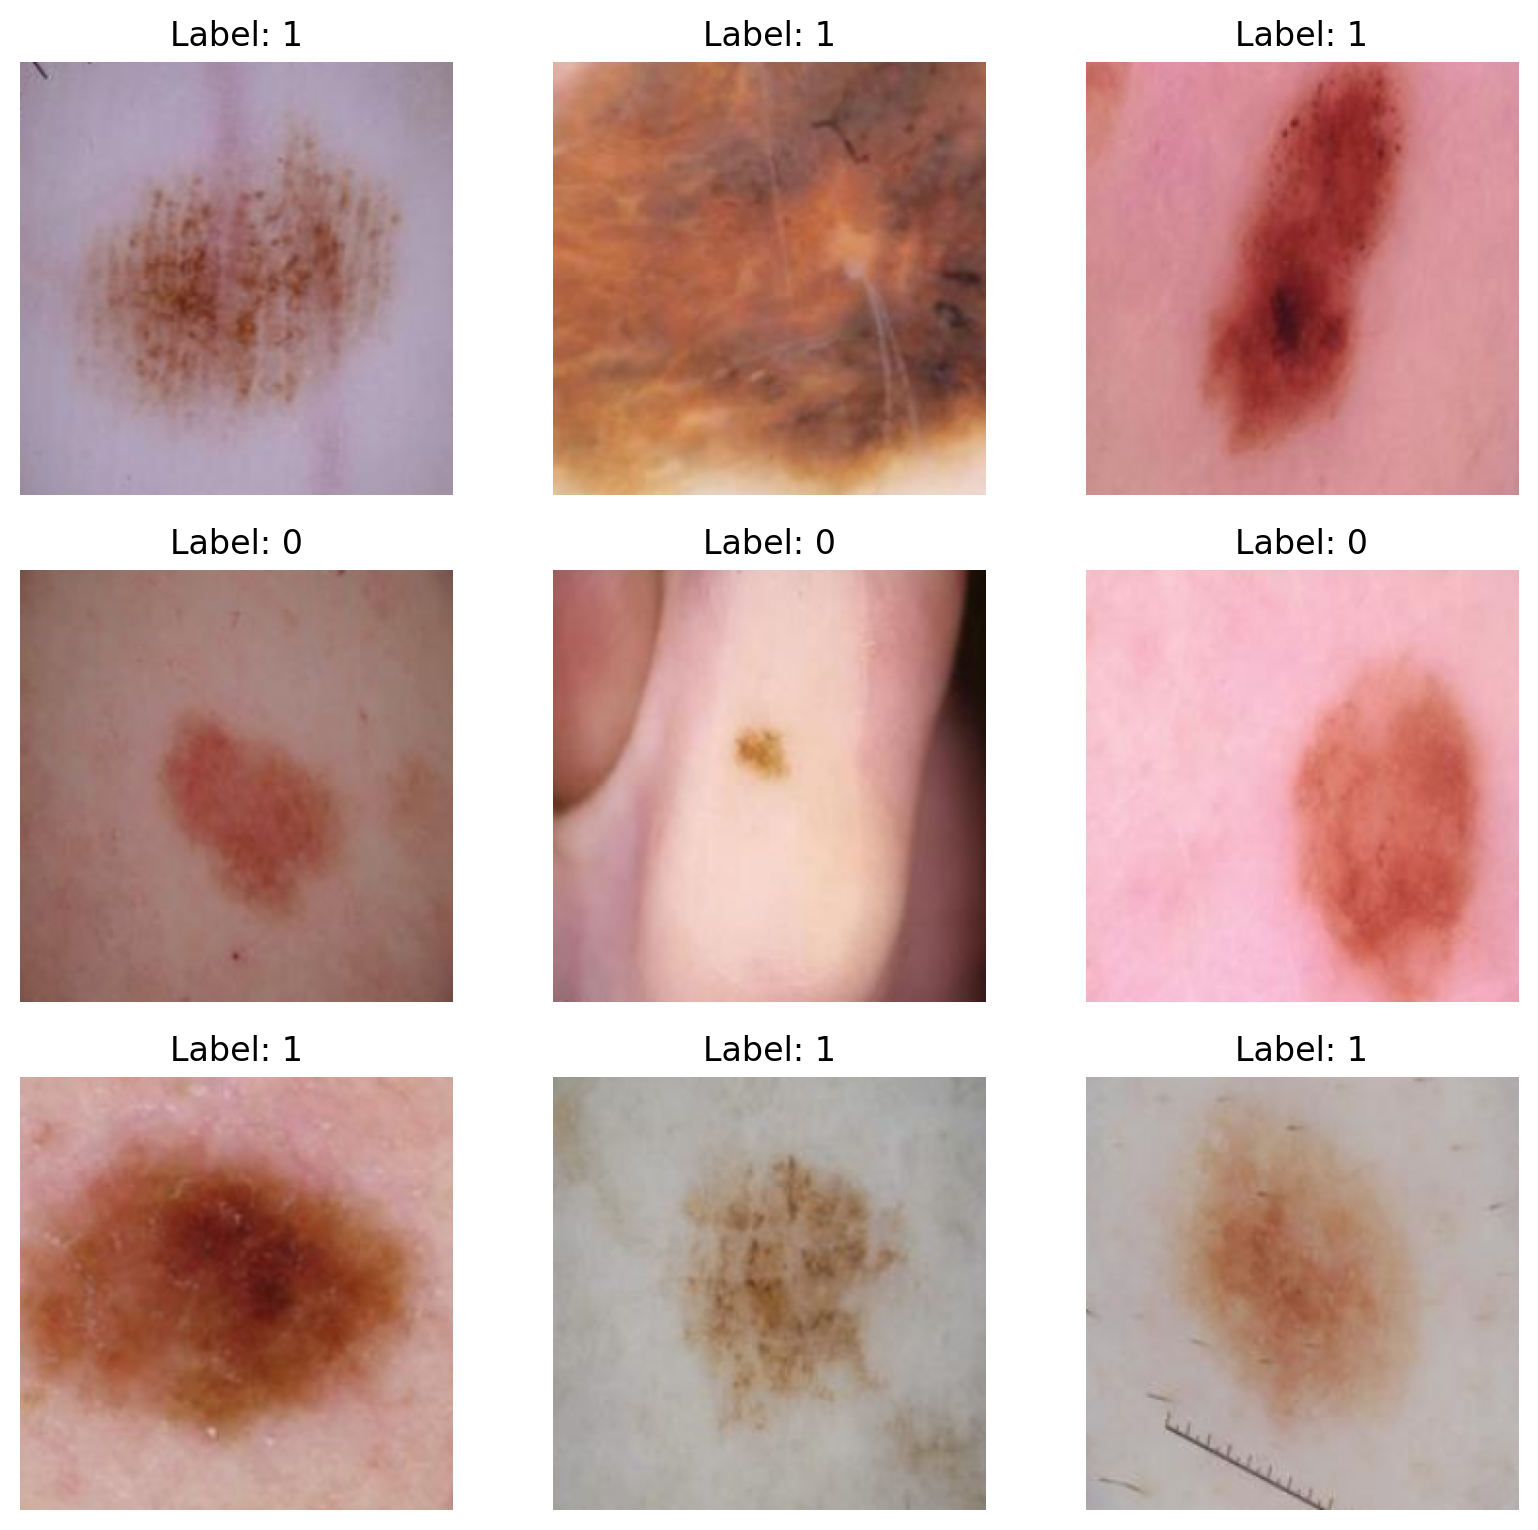

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Undo normalization for display
def denormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

mean = [0.7356305718421936, 0.5613219738006592, 0.5420768857002258]
std  = [0.1998678296804428, 0.19988155364990234, 0.21435679495334625]

fig = plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    img = denormalize(images[i], mean, std)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

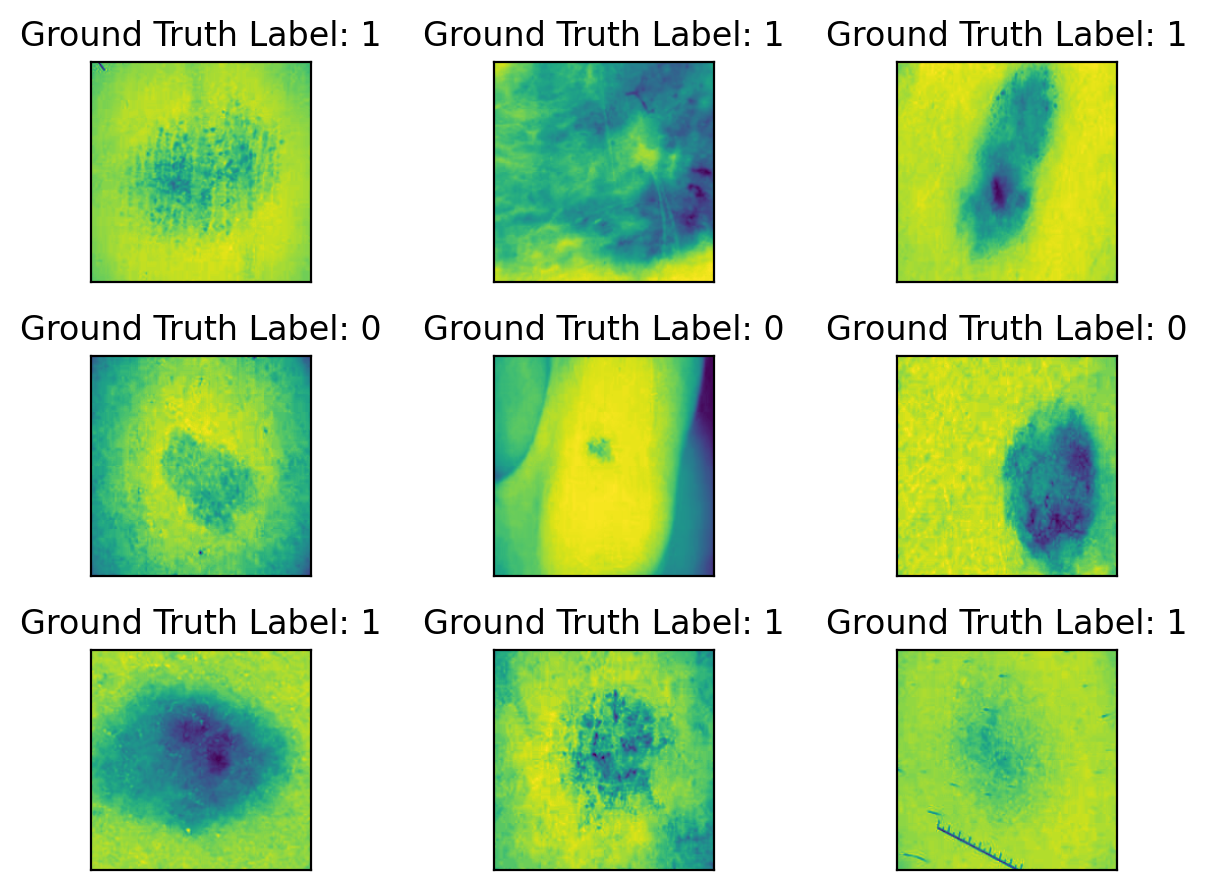

In [ ]:
# Normalized
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0])
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])

Model Build (simple build)

In [ ]:
class MelanomaCNN(nn.Module):
    def __init__(self, num_classes=2, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [ ]:
model = MelanomaCNN()
model.to(device)

MelanomaCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 1

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
import os, time, pickle

SAVE_DIR = '/content/drive/MyDrive/AML Final'
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_PATH    = os.path.join(SAVE_DIR, 'melanoma_model_simple_best.pth')
HISTORY_PATH = os.path.join(SAVE_DIR, 'loss_history_simple.pkl')
best_acc = -1.0  # track best validation accuracy

print('Starting Training')
epochs = 10 # The total number of epochs

train_losses = []
test_losses = []

t0 = time.time()

for epoch in range(epochs):
    t1 = time.time()
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader):

        # Send to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # prep model for evaluation
    model.eval()
    test_loss = 0
    accuracy = 0

    # Turn off the gradients when performing validation.
    with torch.no_grad():
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels)

            probabilities = torch.exp(outputs)
            top_prob, top_class = probabilities.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_losses.append(train_loss/len(trainloader))
    writer.add_scalar('training loss', train_loss/len(trainloader), epoch+1)
    test_losses.append((test_loss/len(testloader)).cpu().numpy())
    writer.add_scalar('testing loss', (test_loss/len(testloader)).cpu().numpy(), epoch+1)

    # save best model checkpoint to Drive
    current_acc = (accuracy/len(testloader)).item() if hasattr(accuracy/len(testloader), 'item') else float(accuracy/len(testloader))
    if current_acc > best_acc:
        best_acc = current_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': best_acc,
            'train_loss': train_losses[-1],
            'val_loss': float(test_losses[-1]),
        }, BEST_PATH)
        print(f'Best model updated @ epoch {epoch+1} | acc={best_acc:.4f} -> {BEST_PATH}')

    # save losses history
    with open(HISTORY_PATH, 'wb') as f:
        pickle.dump({'train_losses': train_losses, 'test_losses': test_losses}, f)

    print("Epoch: {}/{}  ".format(epoch+1, epochs),
          "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
          "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
          "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)),
          "Epoch time: {:.4f}  ".format(time.time() - t1))

print("Training Complete")
print("Total Elapsed Time: {:.4f} ".format(time.time() - t0))
writer.flush()

print(f"Best checkpoint saved to: {BEST_PATH}")
print(f"Loss history saved to:    {HISTORY_PATH}")

Starting Training
Best model updated @ epoch 1 | acc=0.8477 -> /content/drive/MyDrive/AML Final/melanoma_model_simple_best.pth
Epoch: 1/10   Training loss: 0.3840   Testing loss: 0.3317   Test accuracy: 0.8477   Epoch time: 108.2568  
Best model updated @ epoch 2 | acc=0.8535 -> /content/drive/MyDrive/AML Final/melanoma_model_simple_best.pth
Epoch: 2/10   Training loss: 0.3323   Testing loss: 0.3344   Test accuracy: 0.8535   Epoch time: 105.8170  
Best model updated @ epoch 3 | acc=0.8701 -> /content/drive/MyDrive/AML Final/melanoma_model_simple_best.pth
Epoch: 3/10   Training loss: 0.3199   Testing loss: 0.3188   Test accuracy: 0.8701   Epoch time: 102.8913  
Epoch: 4/10   Training loss: 0.3065   Testing loss: 0.3417   Test accuracy: 0.8481   Epoch time: 101.6391  
Best model updated @ epoch 5 | acc=0.8809 -> /content/drive/MyDrive/AML Final/melanoma_model_simple_best.pth
Epoch: 5/10   Training loss: 0.2947   Testing loss: 0.2948   Test accuracy: 0.8809   Epoch time: 101.7142  
Best m

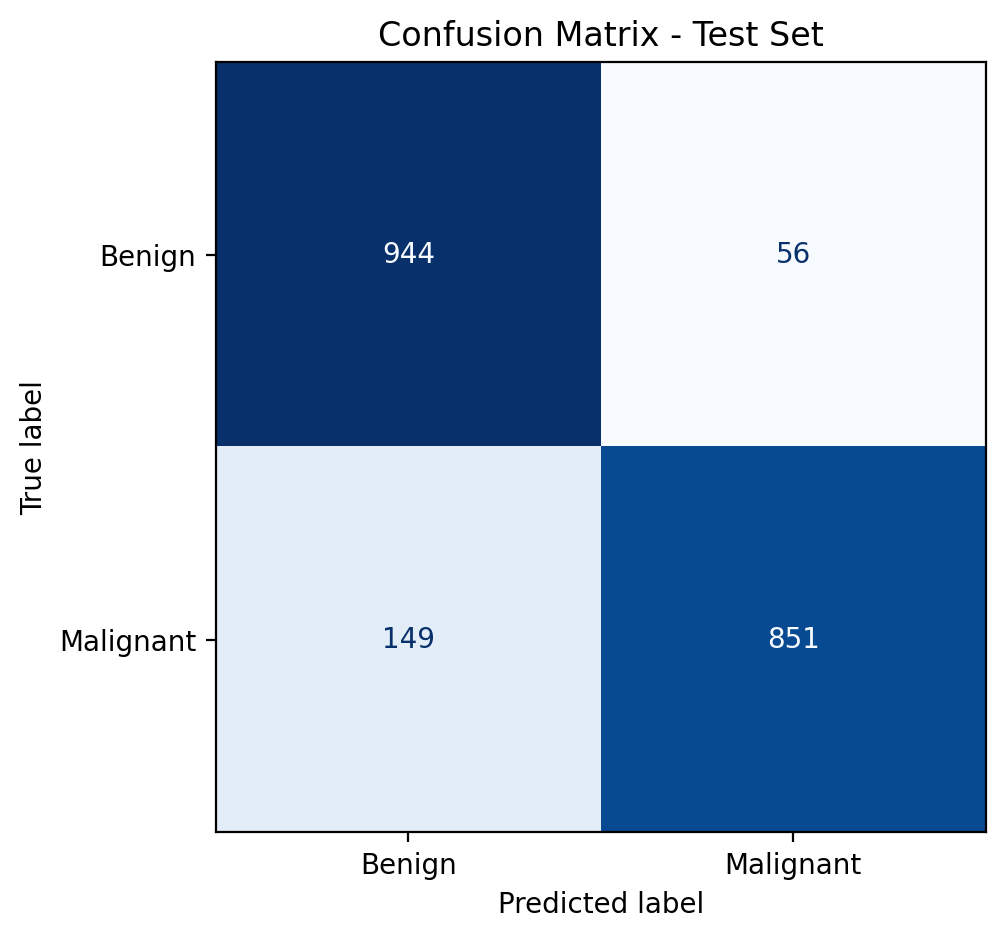

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Test Set")
plt.show()

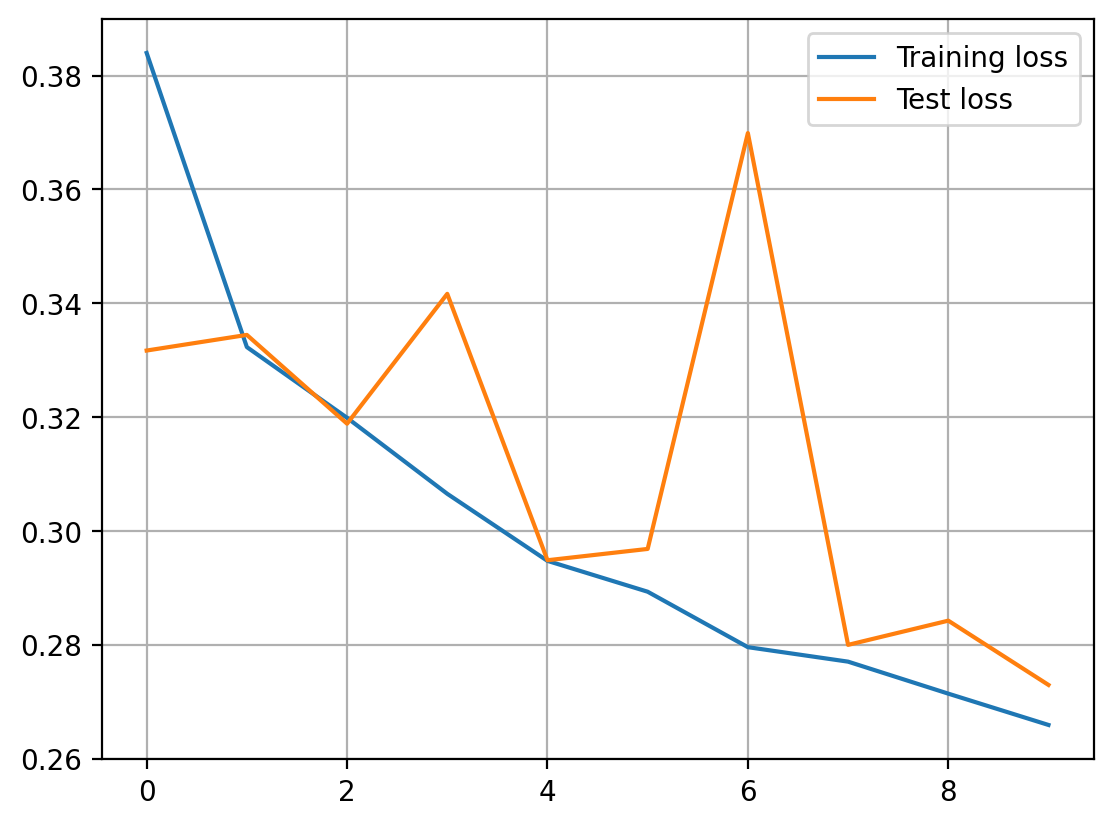

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(np.array([test_loss for test_loss in test_losses]), label='Test loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# select index of image to test
img = images[17]
img = img.to(device)
# img = img.view(-1, 1, 28, 28) # Remove incorrect reshaping
img = img.unsqueeze(0) # Add a batch dimension
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model(img)

torch.Size([1, 3, 224, 224])


[0.04442254 0.95557743]


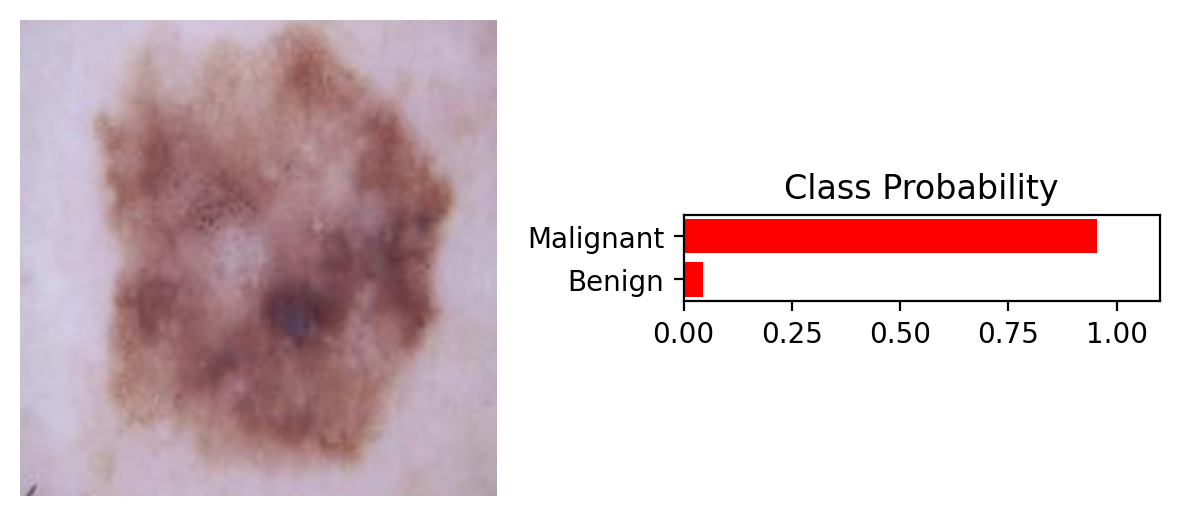

In [ ]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)

# Adjusting imshow for 3-channel image
# Need to undo normalization and permute dimensions for displaying
img_display = denormalize(img.squeeze(0).cpu(), mean, std) # Remove batch dim and denormalize
ax1.imshow(np.transpose(img_display.numpy(), (1, 2, 0))) # Permute dimensions
ax1.axis('off')

# Adjusting bar chart for 2 classes
classes = train_set.classes # Get class names
ax2.barh(np.arange(len(classes)), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(len(classes)))
ax2.set_yticklabels(classes) # Use class names as labels
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()
plt.show()

Model Build (with dropout, LR scheduler, and early stopping)

In [ ]:
class MelanomaCNN2(nn.Module):
    def __init__(self, num_classes=2, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(.1),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d((7,7))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [ ]:
model = MelanomaCNN2()
model.to(device)

MelanomaCNN2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
import os, time, pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau

SAVE_DIR = '/content/drive/MyDrive/AML Final'
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_PATH    = os.path.join(SAVE_DIR, 'melanoma_model_best.pth')
HISTORY_PATH = os.path.join(SAVE_DIR, 'loss_history.pkl')
best_acc = -1.0  # track best validation accuracy

print('Starting Training')
epochs = 10 # The total number of epochs

train_losses = []
test_losses = []

t0 = time.time()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True, min_lr=1e-6)

patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    t1 = time.time()
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader):

        # Send to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # prep model for evaluation
    model.eval()
    test_loss = 0
    accuracy = 0

    # Turn off the gradients when performing validation.
    with torch.no_grad():
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels)

            probabilities = torch.softmax(outputs, dim=1)
            top_prob, top_class = probabilities.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_losses.append(train_loss/len(trainloader))
    writer.add_scalar('training loss', train_loss/len(trainloader), epoch+1)
    test_losses.append((test_loss/len(testloader)).cpu().numpy())
    writer.add_scalar('testing loss', (test_loss/len(testloader)).cpu().numpy(), epoch+1)

    # save best model checkpoint to Drive
    current_acc = (accuracy/len(testloader)).item() if hasattr(accuracy/len(testloader), 'item') else float(accuracy/len(testloader))
    if current_acc > best_acc:
        best_acc = current_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': best_acc,
            'train_loss': train_losses[-1],
            'val_loss': float(test_losses[-1]),
        }, BEST_PATH)
        print(f'Best model updated @ epoch {epoch+1} | acc={best_acc:.4f} -> {BEST_PATH}')

    current_val_loss = (test_loss/len(testloader)).item() if hasattr(test_loss/len(testloader), 'item') else float(test_loss/len(testloader))

    # LR scheduler
    scheduler.step(current_val_loss)

    # Early stopping
    if current_val_loss < best_val_loss - 1e-6:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} (no val-loss improvement for {patience} epochs).")
            break

    # Save losses history
    with open(HISTORY_PATH, 'wb') as f:
        pickle.dump({'train_losses': train_losses, 'test_losses': test_losses}, f)

    print("Epoch: {}/{}  ".format(epoch+1, epochs),
          "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
          "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
          "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)),
          "Epoch time: {:.4f}  ".format(time.time() - t1))

print("Training Complete")
print("Total Elapsed Time: {:.4f} ".format(time.time() - t0))
writer.flush()

print(f"Best checkpoint saved to: {BEST_PATH}")
print(f"Loss history saved to:    {HISTORY_PATH}")

Starting Training
Best model updated @ epoch 1 | acc=0.8657 -> /content/drive/MyDrive/AML Final/melanoma_model_best.pth
Epoch: 1/10   Training loss: 0.3608   Testing loss: 0.3423   Test accuracy: 0.8657   Epoch time: 106.5503  
Epoch: 2/10   Training loss: 0.3443   Testing loss: 0.3227   Test accuracy: 0.8647   Epoch time: 102.5201  
Best model updated @ epoch 3 | acc=0.8799 -> /content/drive/MyDrive/AML Final/melanoma_model_best.pth
Epoch: 3/10   Training loss: 0.3391   Testing loss: 0.3186   Test accuracy: 0.8799   Epoch time: 102.1996  
Epoch: 4/10   Training loss: 0.3355   Testing loss: 0.3185   Test accuracy: 0.8784   Epoch time: 101.1618  
Epoch: 5/10   Training loss: 0.3248   Testing loss: 0.3067   Test accuracy: 0.8750   Epoch time: 102.0749  
Epoch: 6/10   Training loss: 0.3222   Testing loss: 0.3129   Test accuracy: 0.8721   Epoch time: 102.3172  
Epoch: 7/10   Training loss: 0.3150   Testing loss: 0.3121   Test accuracy: 0.8779   Epoch time: 102.1261  
Best model updated @ e

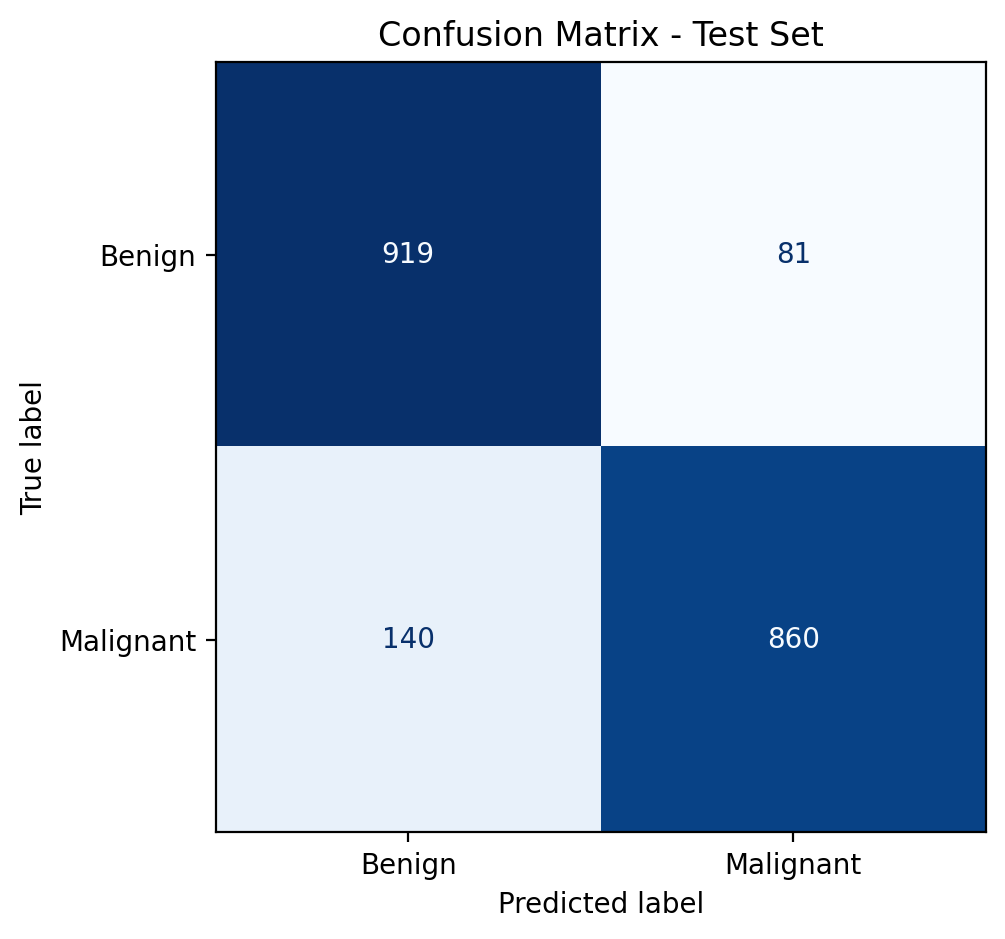

In [ ]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Test Set")
plt.show()

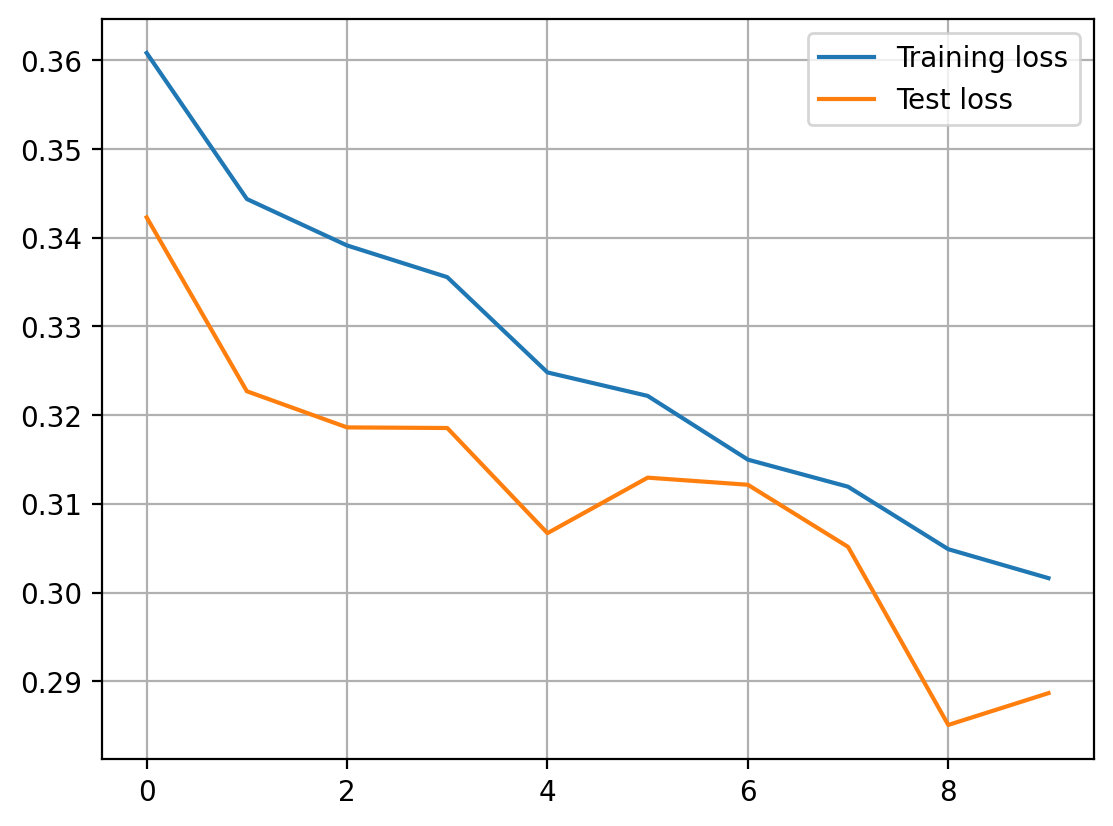

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(np.array([test_loss for test_loss in test_losses]), label='Test loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# select index of image to test
img = images[9]
img = img.to(device)
img = img.unsqueeze(0) # Add a batch dimension
print(img.shape)

with torch.no_grad():
    logits = model(img)

torch.Size([1, 3, 224, 224])


[0.46102324 0.5389768 ]


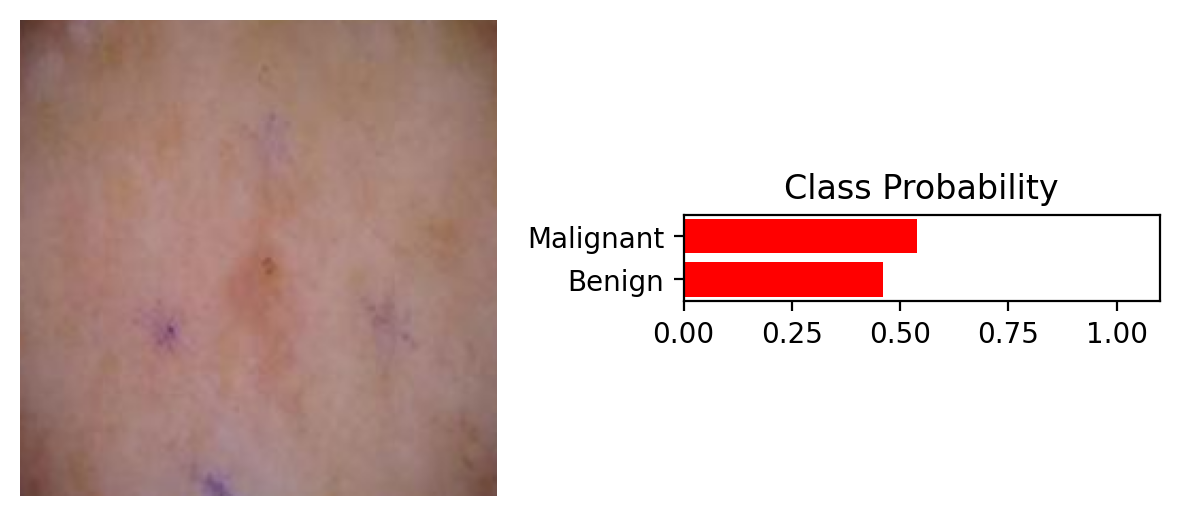

In [ ]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)

# Adjusting imshow for 3-channel image
# Need to undo normalization and permute dimensions for displaying
img_display = denormalize(img.squeeze(0).cpu(), mean, std) # Remove batch dim and denormalize
ax1.imshow(np.transpose(img_display.numpy(), (1, 2, 0))) # Permute dimensions
ax1.axis('off')

# Adjusting bar chart for 2 classes
classes = train_set.classes # Get class names
ax2.barh(np.arange(len(classes)), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(len(classes)))
ax2.set_yticklabels(classes) # Use class names as labels
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()
plt.show()

Transfer Learning Model with resnet18

Re-Transform for ImageNet

In [ ]:
from torchvision import datasets, models, transforms

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

tl_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

tl_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_dir = "/content/archive/train"
test_dir  = "/content/archive/test"

tl_train_set = datasets.ImageFolder(train_dir, transform=tl_train_transform)
tl_test_set  = datasets.ImageFolder(test_dir,  transform=tl_test_transform)

from torch.utils.data import DataLoader
tl_trainloader = DataLoader(tl_train_set, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
tl_testloader  = DataLoader(tl_test_set,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", tl_train_set.classes, tl_train_set.class_to_idx)

Classes: ['Benign', 'Malignant'] {'Benign': 0, 'Malignant': 1}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained resnet18
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze backbone
for p in resnet.parameters():
    p.requires_grad = False

# Replace the classification head for 2 classes
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 2)

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.fc.parameters(), lr=3e-4, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


In [ ]:
import time, os, numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

EPOCHS = 5
BEST_TL_PATH = "/content/drive/MyDrive/AML Final/resnet18_tl_best.pth"
os.makedirs(os.path.dirname(BEST_TL_PATH), exist_ok=True)

best_acc = 0.0
print("Starting training")

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # Train
    resnet.train()
    running_loss = 0.0

    for imgs, labels in tl_trainloader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = resnet(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(tl_trainloader)

    # Validate
    resnet.eval()
    val_loss = 0.0
    all_t, all_p, all_pb = [], [], []

    with torch.no_grad():
        for imgs, labels in tl_testloader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = resnet(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)

            all_t.extend(labels.cpu().numpy())
            all_p.extend(preds.cpu().numpy())
            all_pb.extend(probs[:,1].cpu().numpy())

    val_loss /= len(tl_testloader)
    acc = accuracy_score(all_t, all_p)
    f1  = f1_score(all_t, all_p, average='binary')
    try:
        auc = roc_auc_score(all_t, all_pb)
    except:
        auc = float('nan')

    if acc > best_acc:
        best_acc = acc
        torch.save({'model_state': resnet.state_dict(),
                    'best_acc': best_acc,
                    'epoch': epoch}, BEST_TL_PATH)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss {train_loss:.4f} | "
          f"val_loss {val_loss:.4f} | acc {acc:.4f} | f1 {f1:.4f} | auc {auc:.4f} "
          f"| {time.time()-t0:.1f}s")

print(f"Done. Best val acc: {best_acc:.4f} | Saved to {BEST_TL_PATH}")

Starting training
Epoch 01/5 | train_loss 0.4489 | val_loss 0.4031 | acc 0.8220 | f1 0.8104 | auc 0.9129 | 43.6s
Epoch 02/5 | train_loss 0.3530 | val_loss 0.3705 | acc 0.8350 | f1 0.8205 | auc 0.9314 | 41.8s
Epoch 03/5 | train_loss 0.3388 | val_loss 0.3665 | acc 0.8365 | f1 0.8204 | auc 0.9366 | 41.5s
Epoch 04/5 | train_loss 0.3331 | val_loss 0.3527 | acc 0.8480 | f1 0.8346 | auc 0.9421 | 41.3s
Epoch 05/5 | train_loss 0.3207 | val_loss 0.3465 | acc 0.8540 | f1 0.8415 | auc 0.9437 | 42.8s
Done. Best val acc: 0.8540 | Saved to /content/drive/MyDrive/AML Final/resnet18_tl_best.pth


Confusion matrix:
 [[933  67]
 [225 775]]

Classification report:
               precision    recall  f1-score   support

      Benign       0.81      0.93      0.86      1000
   Malignant       0.92      0.78      0.84      1000

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000

ROC-AUC: 0.9437


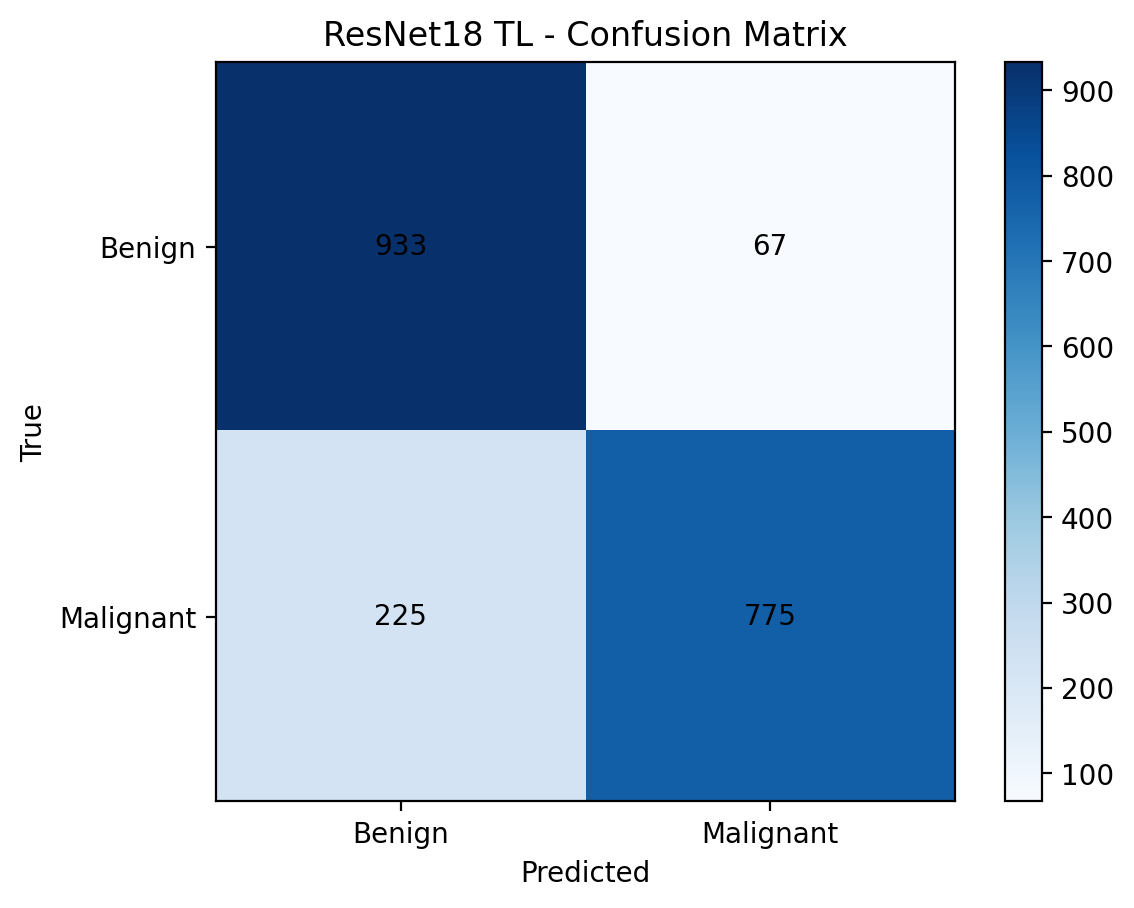

In [ ]:
resnet.eval()

all_t, all_p, all_pb = [], [], []
with torch.no_grad():
    for imgs, labels in tl_testloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = resnet(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(1)
        all_t.extend(labels.cpu().numpy())
        all_p.extend(preds.cpu().numpy())
        all_pb.extend(probs[:,1].cpu().numpy())

cm = confusion_matrix(all_t, all_p, labels=[0,1])
print("Confusion matrix:\n", cm)
print("\nClassification report:\n",
      classification_report(all_t, all_p, target_names=['Benign','Malignant']))
try:
    print(f"ROC-AUC: {roc_auc_score(all_t, all_pb):.4f}")
except:
    pass

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Benign','Malignant']); ax.set_yticklabels(['Benign','Malignant'])
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.colorbar(im); plt.title('ResNet18 TL - Confusion Matrix'); plt.show()